# Machine Learning Methods and Model Comparison

### 1. Purpose of the Machine Learning Analysis

While hypothesis testing focuses on evaluating specific relationships between earthquake risk and rental prices, it does not aim to optimize predictive performance.

In this section, we apply multiple machine learning models to predict the log-transformed rental price per square meter using both apartment-level characteristics and neighborhood-level earthquake risk indicators.

The objectives of this analysis are:
- to compare linear and non-linear modeling approaches,
- to evaluate how well different algorithms generalize to unseen data,
- to identify the most suitable model for capturing complex price dynamics in Istanbul’s rental housing market.

### 2. Target Variable and Feature Set

The dependent variable is the natural logarithm of rental price per square meter, which is used to reduce skewness and stabilize variance.

The feature set includes structural apartment characteristics as well as earthquake-related risk indicators: area_m2, age, floor, room, living_room, damage_ratio, casualty_ratio, earthquake_risk_index


In [78]:
df = merged_df.copy()

df = df[df["price_per_m2"] > 0].copy()

df["log_price_per_m2"] = np.log(df["price_per_m2"])

feature_cols = [
    "area_m2", "age", "floor",
    "room", "living_room",
    "damage_ratio", "casualty_ratio",
    "earthquake_risk_index"
]

X = df[feature_cols]
y = df["log_price_per_m2"]

print(X.shape, y.shape)
X.head()

(11176, 8) (11176,)


,area_m2,age,floor,room,living_room,damage_ratio,casualty_ratio,earthquake_risk_index
0,90,45,3,2,1,0.182283,0.217206,0.389421
1,150,11,0,3,1,0.028513,0.000000,0.031349
2,68,35,1,2,1,0.205853,0.139253,0.347501
3,90,1,-2,2,1,0.155313,0.193460,0.339107
4,65,42,1,1,1,0.233611,0.172825,0.407234


### 3. Cross-Validation Strategy

All models are evaluated using 5-fold cross-validation to ensure robust and unbiased performance estimates.

The dataset is split into five folds. In each iteration, four folds are used for training and one fold is used for testing. The reported metrics represent the mean and standard deviation across all folds. Shuffling is applied to ensure that each fold is representative of the overall data distribution.


In [79]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error, make_scorer

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(name, model, X, y, cv):
    scores = cross_validate(
        model, X, y,
        cv=cv,
        scoring={"r2": "r2", "rmse": rmse_scorer},
        return_train_score=False
    )
    return {
        "Model": name,
        "CV R2 (mean)": scores["test_r2"].mean(),
        "CV R2 (std)": scores["test_r2"].std(),
        "CV RMSE (mean)": (-scores["test_rmse"]).mean(),
        "CV RMSE (std)": (-scores["test_rmse"]).std()
    }

### 4. Visualization Setup

To ensure consistent and readable visual diagnostics across models, we define a common plotting function that displays a sampled version of predicted versus actual values. This approach reduces overplotting while preserving the overall prediction structure and comparability across models. To further improve interpretability, the visualization focuses on the central percentile range of the target variable.

In [80]:
def plot_pred_vs_actual_sampled(y_true, y_pred, title, sample_n=2000, q_low=1, q_high=99, seed=42):
    np.random.seed(seed)
    plot_df = pd.DataFrame({"actual": y_true, "pred": y_pred})

    if sample_n is not None and sample_n < len(plot_df):
        plot_df = plot_df.sample(n=sample_n, random_state=seed)

    lo = np.percentile(y_true, q_low)
    hi = np.percentile(y_true, q_high)

    plt.figure(figsize=(6,6))
    plt.scatter(plot_df["actual"], plot_df["pred"], alpha=0.35, s=20)
    plt.plot([lo, hi], [lo, hi], "r--")
    plt.xlim(lo, hi)
    plt.ylim(lo, hi)
    plt.xlabel("Actual log(price_per_m2)")
    plt.ylabel("Predicted log(price_per_m2)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

### 5. Baseline Model: Linear Regression

We begin with Multiple Linear Regression as a baseline model. This approach assumes linear relationships between predictors and rental prices and serves as a reference point for more flexible machine learning methods.

In [81]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
res_lr = evaluate_model("Linear Regression", lr, X, y, cv)
res_lr

{'Model': 'Linear Regression',
 'CV R2 (mean)': np.float64(0.12626039439725895),
 'CV R2 (std)': np.float64(0.031048218201298057),
 'CV RMSE (mean)': np.float64(0.6801982079246127),
 'CV RMSE (std)': np.float64(0.025191251256456354)}

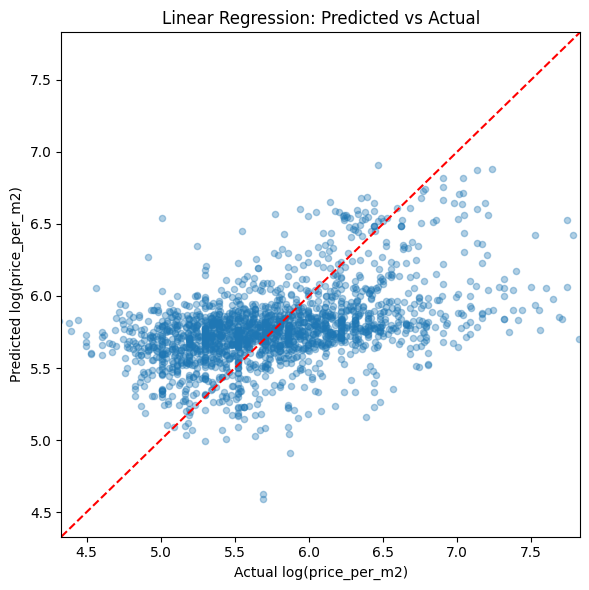

In [82]:
from sklearn.model_selection import cross_val_predict

y_pred_lr = cross_val_predict(lr, X, y, cv=cv)

plot_pred_vs_actual_sampled(
    y_true=y,
    y_pred=y_pred_lr,
    title="Linear Regression: Predicted vs Actual",
    sample_n=2000
)

##### Strengths
- Simple and interpretable baseline model.
- Provides a clear reference point for evaluating non-linear methods.
##### Weaknesses 
- Assumes a purely linear relationship between predictors and rental prices.
- Fails to capture interactions and non-linear effects present in the data.
##### Interpretation
The low cross-validated R² indicates that linear assumptions are insufficient to explain rental price variation in Istanbul. This suggests that the relationship between apartment characteristics, earthquake risk, and rent is inherently non-linear.

### 6. Non-Linear Models

#### 6.1 K-Nearest Neighbors (KNN)

KNN is a non-parametric, instance-based model that predicts rental prices by averaging nearby observations in feature space. Features are standardized due to distance sensitivity.

In [83]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor(n_neighbors=15))
])

res_knn = evaluate_model("KNN (k=15, scaled)", knn, X, y, cv)
res_knn

{'Model': 'KNN (k=15, scaled)',
 'CV R2 (mean)': np.float64(0.3076228903216472),
 'CV R2 (std)': np.float64(0.02452672090559059),
 'CV RMSE (mean)': np.float64(0.6055763368494131),
 'CV RMSE (std)': np.float64(0.024240863201104104)}

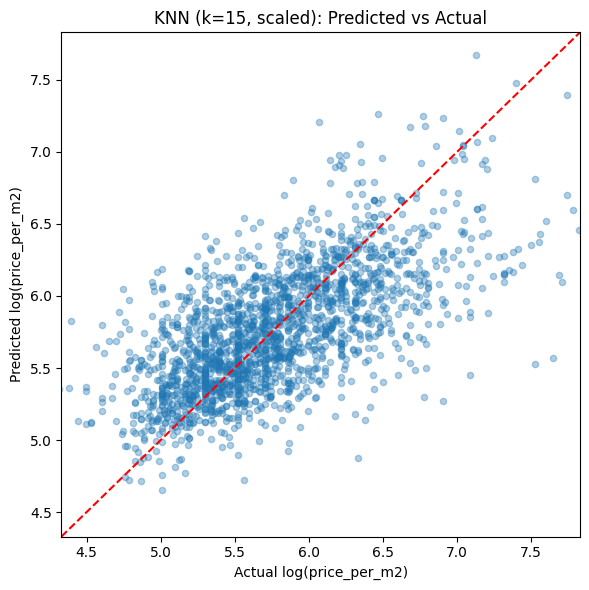

In [84]:
y_pred_knn = cross_val_predict(knn, X, y, cv=cv)

plot_pred_vs_actual_sampled(
    y_true=y,
    y_pred=y_pred_knn,
    title="KNN (k=15, scaled): Predicted vs Actual",
    sample_n=2000
)

##### Strengths
- Captures local, non-linear patterns without assuming a global functional form.
- Performs substantially better than the linear baseline.

##### Weaknesses
- Sensitive to feature scaling and the choice of the number of neighbors.
- Predictive performance may degrade in sparse regions of the feature space.

##### Interpretation

The improved R² relative to linear regression indicates that nearby apartments in feature space tend to have similar rental prices. However, KNN remains limited in capturing broader structural patterns across the city.

#### 6.2 Decision Tree

Decision Trees capture non-linear interactions through recursive splits but may suffer from instability if not constrained.

In [85]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=10, random_state=42)
res_dt = evaluate_model("Decision Tree (max_depth=10)", dt, X, y, cv)
res_dt

{'Model': 'Decision Tree (max_depth=10)',
 'CV R2 (mean)': np.float64(0.16981683184109586),
 'CV R2 (std)': np.float64(0.019044920522854145),
 'CV RMSE (mean)': np.float64(0.6629825155361919),
 'CV RMSE (std)': np.float64(0.01940906874420687)}

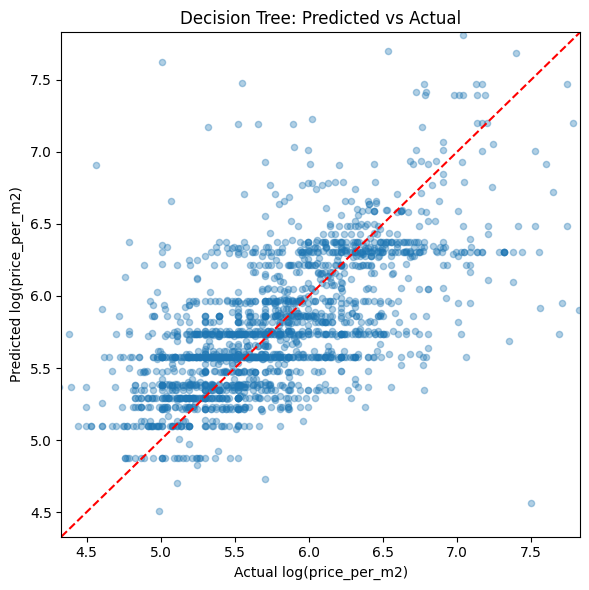

In [86]:
y_pred_dt = cross_val_predict(dt, X, y, cv=cv)

plot_pred_vs_actual_sampled(
    y_true=y,
    y_pred=y_pred_dt,
    title="Decision Tree: Predicted vs Actual",
    sample_n=2000
)

##### Strengths
- Automatically captures non-linear relationships and feature interactions.
- Easy to interpret compared to ensemble methods.

##### Weaknesses
- Prone to instability and higher variance.
- Weaker generalization performance compared to ensemble approaches.

##### Interpretation

Although the Decision Tree captures some non-linear structure, its relatively modest cross-validated performance suggests that a single tree is insufficient to robustly model rental price dynamics across Istanbul. The horizontal banding observed in the prediction plot reflects the piecewise-constant nature of tree-based predictions.

#### 6.3 Random Forest 

Random Forest aggregates multiple decorrelated decision trees to reduce variance and improve generalization. This model is expected to capture complex interactions between apartment features and earthquake risk indicators.

In [87]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

res_rf = evaluate_model("Random Forest (300 trees)", rf, X, y, cv)
res_rf

{'Model': 'Random Forest (300 trees)',
 'CV R2 (mean)': np.float64(0.3750668001059152),
 'CV R2 (std)': np.float64(0.013839116581588401),
 'CV RMSE (mean)': np.float64(0.5753167287574145),
 'CV RMSE (std)': np.float64(0.01974255665570905)}

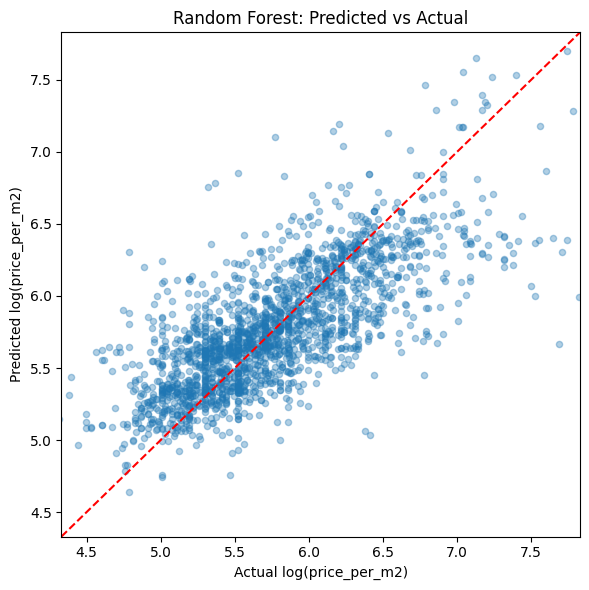

In [88]:
y_pred_rf = cross_val_predict(rf, X, y, cv=cv)

plot_pred_vs_actual_sampled(
    y_true=y,
    y_pred=y_pred_rf,
    title="Random Forest: Predicted vs Actual",
    sample_n=2000
)

##### Strengths
- Aggregates multiple decorrelated trees to reduce variance.
- Achieves the highest predictive accuracy and stability among all tested models.

##### Weaknesses
- Less interpretable than single-tree models without additional tools.
- Still limited by the available feature set.

##### Interpretation

Random Forest consistently outperforms other models, indicating that rental prices are shaped by complex interactions between apartment features and earthquake risk indicators. Its superior stability across folds suggests strong generalization ability.

### 7. Model Performance Comparison

In [89]:

comparison_df = results_df.copy()

num_cols = [
    "CV R2 (mean)", "CV R2 (std)",
    "CV RMSE (mean)", "CV RMSE (std)"
]

comparison_df[num_cols] = comparison_df[num_cols].astype(float)

comparison_df[num_cols] = comparison_df[num_cols].round(3)

comparison_df["Performance Summary"] = [
    "Weak linear baseline",
    "Captures local non-linear patterns",
    "Non-linear but unstable",
    "Best accuracy and stability"
]
comparison_df

,Model,CV R2 (mean),CV R2 (std),CV RMSE (mean),CV RMSE (std),Performance Summary
0,Linear Regression,0.126,0.031,0.680,0.025,Weak linear baseline
1,"KNN (k=15, scaled)",0.308,0.025,0.606,0.024,Captures local non-linear patterns
2,Decision Tree (max_depth=10),0.170,0.019,0.663,0.019,Non-linear but unstable
3,Random Forest (300 trees),0.375,0.014,0.575,0.020,Best accuracy and stability


#### Key Takeaways
- Non-linear models outperform the linear baseline, confirming that rental price formation in Istanbul is not well described by linear relationships alone.
- Random Forest achieves the best overall performance, balancing predictive accuracy and stability across cross-validation folds.
- Earthquake risk indicators contribute meaningfully to prediction, but structural apartment characteristics remain the dominant drivers of rental prices.
- Moderate R² values across all models indicate that important explanatory factors—such as neighborhood amenities, building quality, and market conditions—are not fully captured in the dataset.

### 8. Overall Summary 
This machine learning analysis complements the earlier exploratory and hypothesis-testing results by focusing on predictive performance rather than isolated statistical relationships.

Across all tested models, non-linear approaches consistently outperform the linear baseline, indicating that rental prices in Istanbul are shaped by complex and interacting factors rather than simple linear effects. Among these models, Random Forest achieves the strongest and most stable performance among the tested models under 5-fold cross-validation, suggesting that ensemble-based methods are better suited for capturing the structure of the data.

Despite these improvements, the moderate R² values highlight an important limitation: rental prices are influenced by additional unobserved factors that are not fully represented in the current feature set. These include neighborhood amenities, construction quality, and broader market conditions. As such, the results should be interpreted as evidence of meaningful but partial explanatory power rather than complete price determination.